In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow
import zipfile



In [ ]:
with zipfile.ZipFile('/content/archive.zip', 'r') as zip_ref:
  zip_ref.extractall('CELEBimg')



In [ ]:
with zipfile.ZipFile('/content/harshit_project.zip', 'r') as zip_ref:
  zip_ref.extractall('Project_fakeusers')


Found 1800 files belonging to 17 classes.


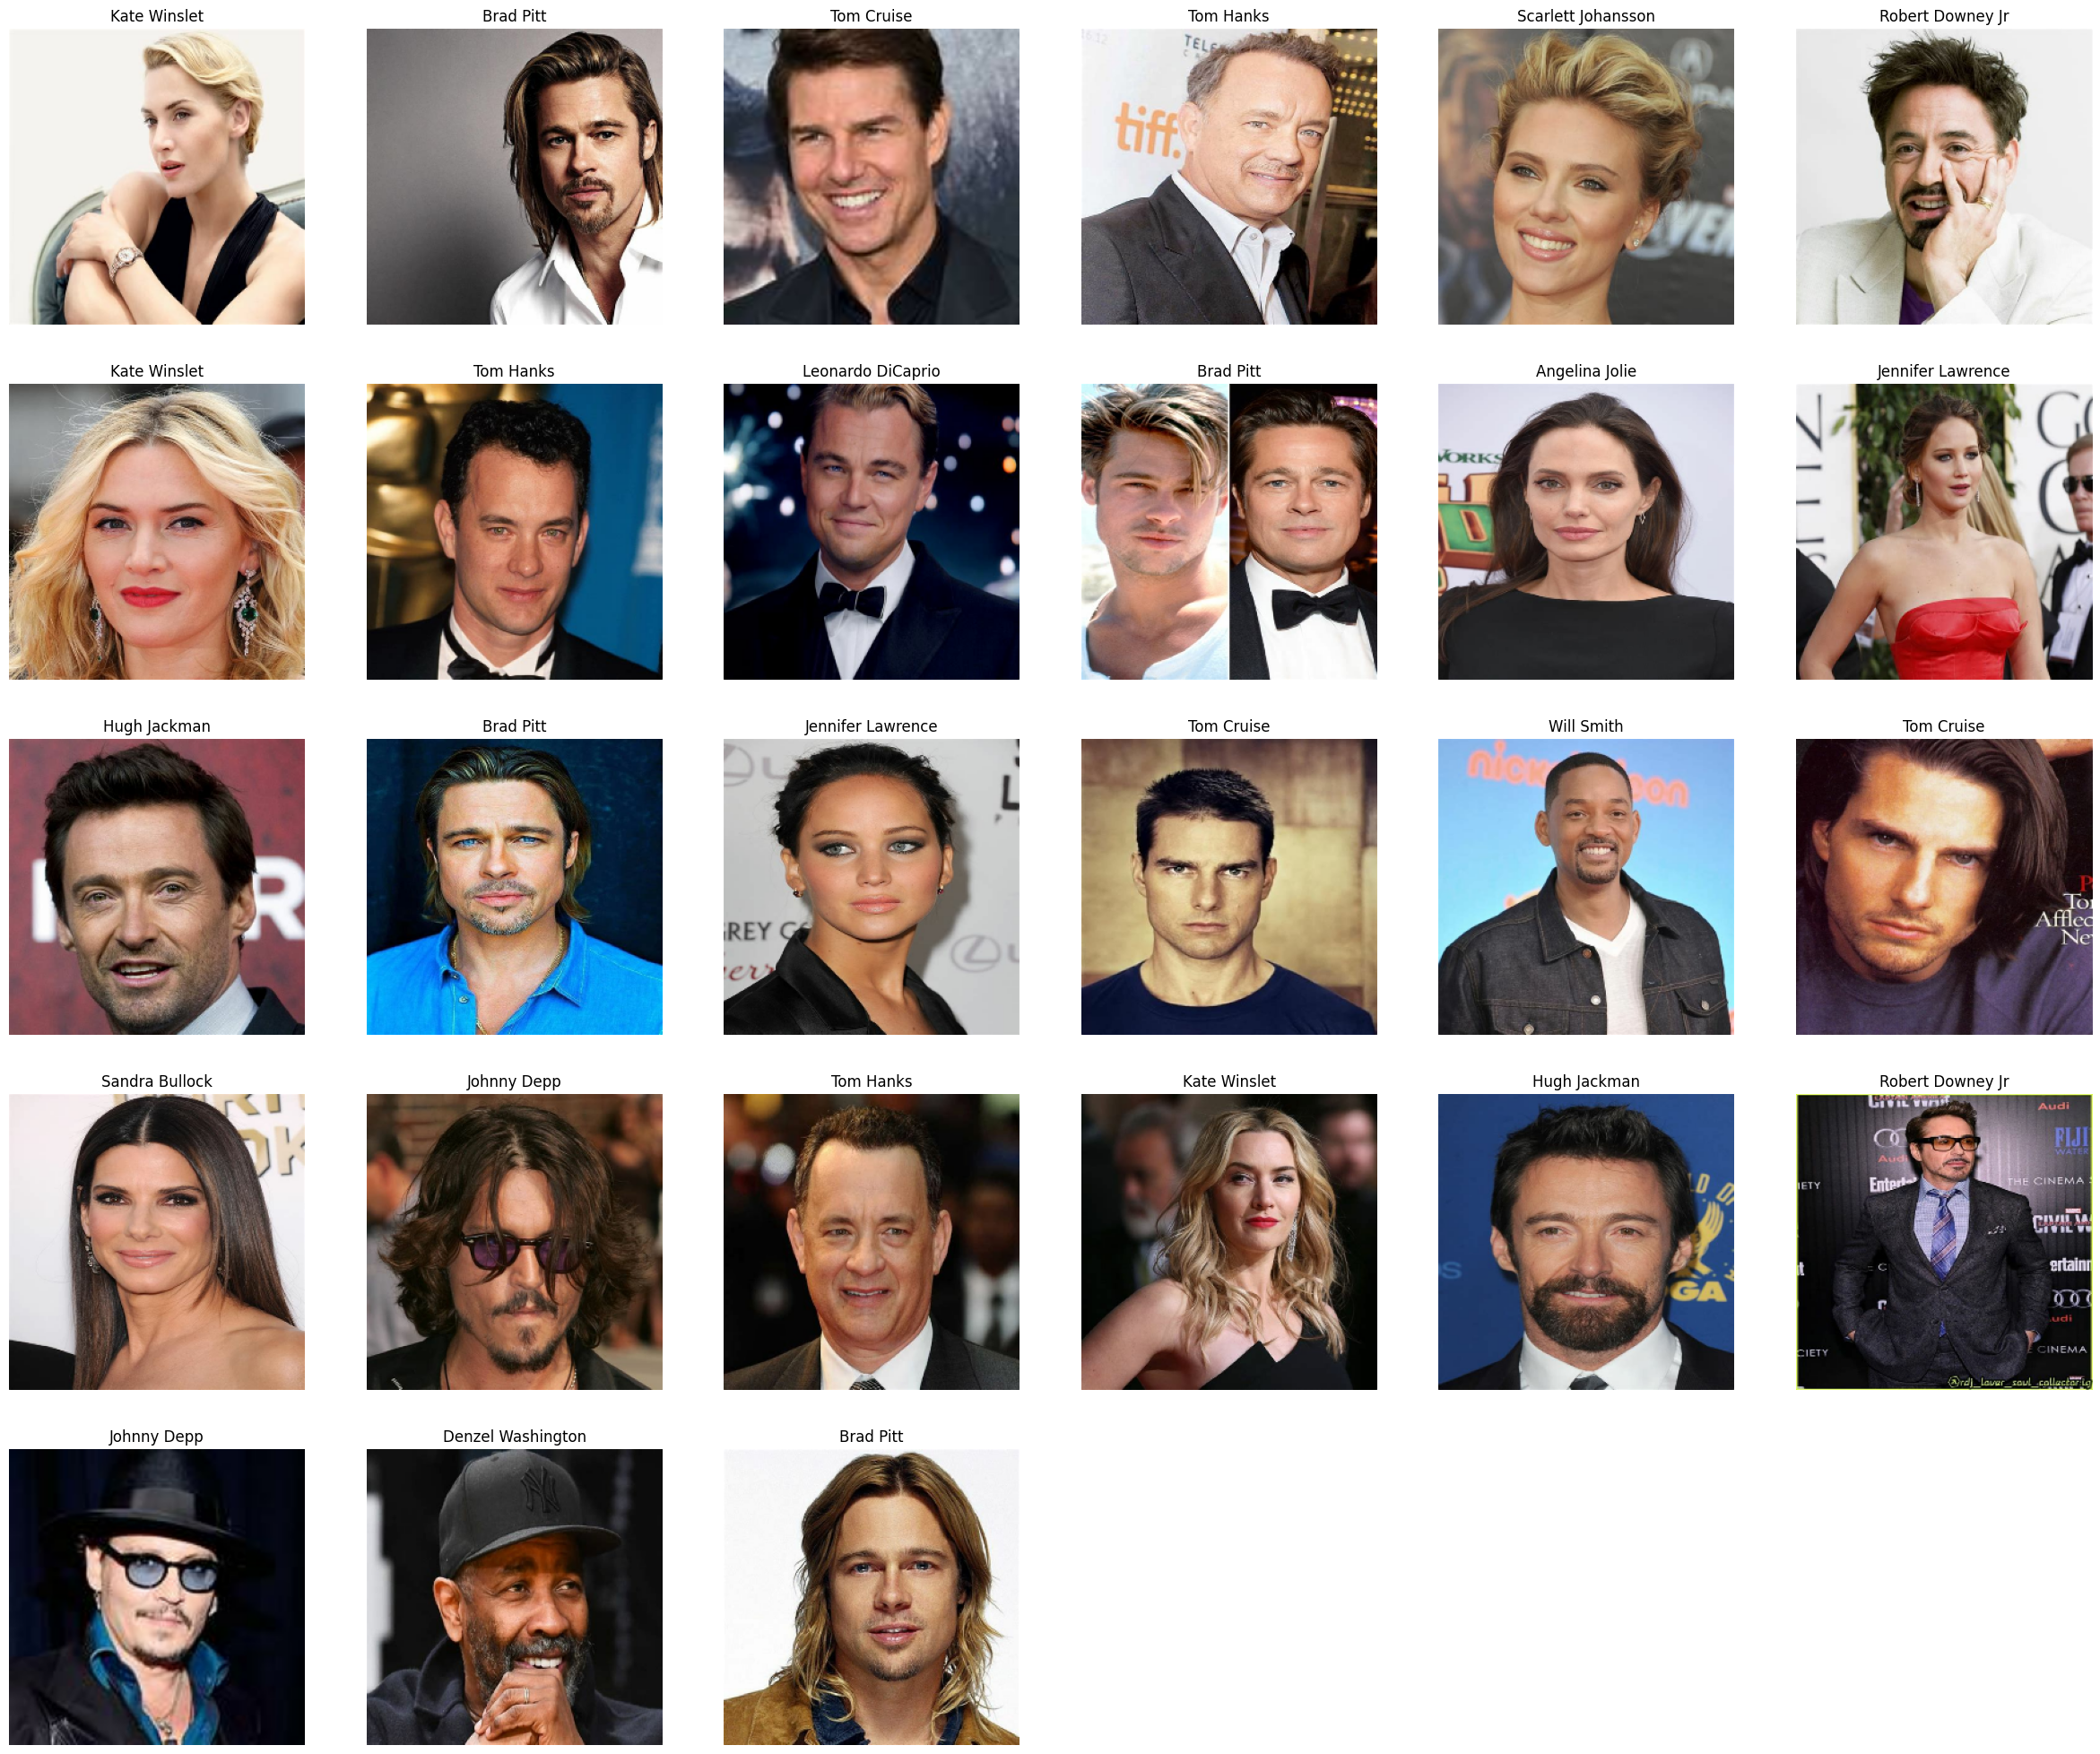

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

df = image_dataset_from_directory(
    '/content/CELEBimg/Celebrity Faces Dataset',
    image_size=(256, 256),
    batch_size=256,
    label_mode='int'
)

import matplotlib.pyplot as plt

class_names = df.class_names
plt.figure(figsize=(30, 30))
for images, labels in df.take(1):
    for i in range(27):
        ax = plt.subplot(6, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()


In [ ]:
normalization_layer = tensorflow.keras.layers.Rescaling(1./255)
normalized_df = df.map(lambda x, y: (normalization_layer(x), y))


In [ ]:
import keras
from keras import layers
from keras import ops


In [ ]:
num_classes = 17
input_shape = (256, 256, 3)



import numpy as np

def dataset_to_numpy(dataset):
    images = []
    labels = []
    for batch in dataset:
        for image, label in zip(batch[0], batch[1]):
            images.append(image.numpy())
            labels.append(label.numpy())
    return np.array(images), np.array(labels)

images, labels = dataset_to_numpy(df)




In [ ]:
print(labels[:11])
print(images[:5])

[12 10  1  0  0 13 14  7  7 10  8]
[[[[ 21.        50.       106.      ]
   [ 21.        50.       106.      ]
   [ 20.9375    50.0625   106.      ]
   ...
   [ 40.        94.       154.      ]
   [ 40.        94.       154.      ]
   [ 40.        94.       154.      ]]

  [[ 21.        50.       106.      ]
   [ 21.        50.       106.      ]
   [ 20.9375    50.0625   106.      ]
   ...
   [ 40.        94.       154.      ]
   [ 40.        94.       154.      ]
   [ 40.        94.       154.      ]]

  [[ 21.        50.       106.      ]
   [ 21.        50.       106.      ]
   [ 20.9375    50.0625   106.      ]
   ...
   [ 40.        94.       154.      ]
   [ 40.        94.       154.      ]
   [ 40.        94.       154.      ]]

  ...

  [[ 24.875     46.0625   109.      ]
   [ 24.027344  46.5      109.      ]
   [ 22.6875    47.125    108.8125  ]
   ...
   [195.08594  200.14453  206.07812 ]
   [199.1836   205.4336   211.52344 ]
   [202.4375   209.5625   215.625   ]]

  [[ 25.  

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

print(f"X_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"X_test shape: {x_test.shape} - y_test shape: {y_test.shape}")


X_train shape: (1440, 256, 256, 3) - y_train shape: (1440,)
X_test shape: (360, 256, 256, 3) - y_test shape: (360,)


In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 72
patch_size = 6
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]
transformer_layers = 8
mlp_head_units = [
    2048,
    1024,
]

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = ops.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = keras.ops.image.extract_patches(images, size=self.patch_size)
        patches = ops.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            ),
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


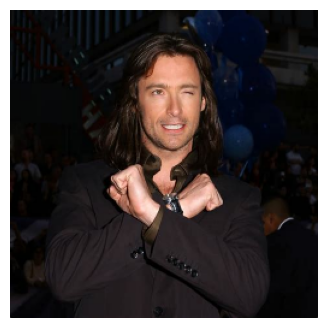

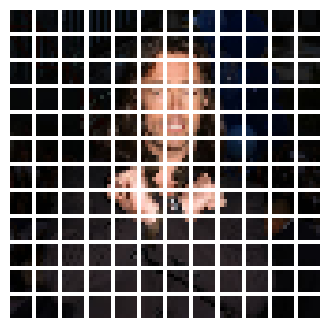

In [ ]:
plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = ops.image.resize(
    ops.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = ops.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(ops.convert_to_numpy(patch_img).astype("uint8"))
    plt.axis("off")

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = ops.expand_dims(
            ops.arange(start=0, stop=self.num_patches, step=1), axis=0
        )
        projected_patches = self.projection(patch)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config

In [ ]:
def create_vit_classifier():
    inputs = keras.Input(shape=input_shape)

    augmented = data_augmentation(inputs)

    patches = Patches(patch_size)(augmented)

    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
    for _ in range(transformer_layers):

        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)

        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        encoded_patches = layers.Add()([x3, x2])
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)

    logits = layers.Dense(num_classes)(features)
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

Epoch 1/256
7/7 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step - accuracy: 0.0757 - loss: 8.7653 - top-5-accuracy: 0.2916 - val_accuracy: 0.0417 - val_loss: 3.9384 - val_top-5-accuracy: 0.2708
Epoch 2/256
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.0679 - loss: 4.4433 - top-5-accuracy: 0.3438 - val_accuracy: 0.1389 - val_loss: 2.7927 - val_top-5-accuracy: 0.3819
Epoch 3/256
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 384ms/step - accuracy: 0.1180 - loss: 3.0437 - top-5-accuracy: 0.3963 - val_accuracy: 0.1250 - val_loss: 2.7458 - val_top-5-accuracy: 0.5069
Epoch 4/256
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 391ms/step - accuracy: 0.1136 - loss: 2.9252 - top-5-accuracy: 0.4125 - val_accuracy: 0.1319 - val_loss: 2.7442 - val_top-5-accuracy: 0.4306
Epoch 5/256
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 384ms/step - accuracy: 0.1342 - loss: 2.7946 - top-5-accuracy: 0.4422 - val_accuracy: 0.1389 - val_loss: 2.7033 - val_top-5-accuracy: 0.4306
Epoch 6/256
7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.1808 - loss: 2.7028 - top-5-accurac

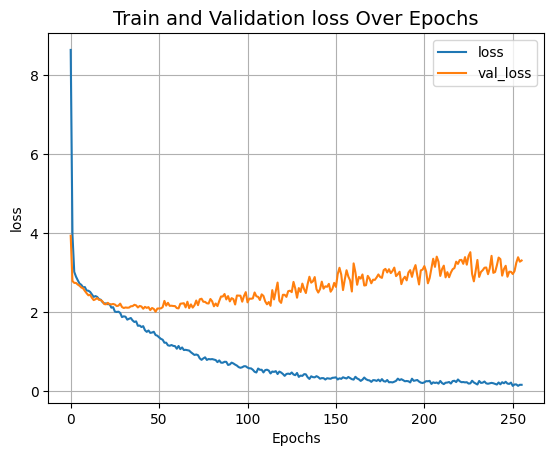

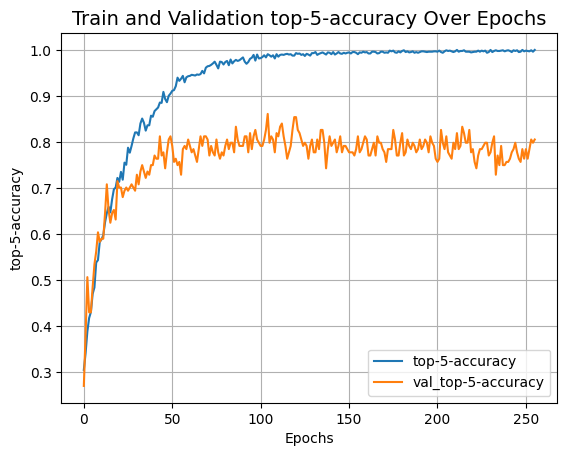

In [ ]:
def run_experiment(model):
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)


def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_history("loss")
plot_history("top-5-accuracy")

In [ ]:
df_fusers = pd.read_csv("dataset/fusers.csv")
df_users = pd.read_csv("dataset/users.csv")

df_users['isFake'] = 0
df_fusers['isFake'] = 1


In [ ]:
df_allUsers = pd.concat([df_fusers, df_users], ignore_index=True)
df_allUsers = df_allUsers.sample(frac=1).reset_index(drop=True)


In [ ]:
X = df_allUsers.drop(["isFake"], axis=1)
Y = df_allUsers['isFake']
print(X['lang'].head)
print(df_allUsers.head())


<bound method NDFrame.head of 0       en
1       en
2       en
3       es
4       en
        ..
6820    en
6821    en
6822    en
6823    es
6824    en
Name: lang, Length: 6825, dtype: object>
          id              name      screen_name  statuses_count  \
0  620111964       Trisha Hull          hullwgo              37   
1  616993101      Caryn Mccray   carynmccrayjas              33   
2  553317912             C-Mac           C_Mvck            3621   
3  630700348  elizabeth lagos   elizabethlagos6               5   
4  621615487      Emily Franco         emilslay            4303   

   followers_count  friends_count  favourites_count  listed_count  \
0               21            294                 0             0   
1               20            348                 0             0   
2               73             71               156             0   
3                4            570                 0             0   
4              611            404              3812         

In [ ]:

X = X[[
    "statuses_count",
    "followers_count",
    "friends_count",
    "favourites_count",
    "lang",
    "listed_count",
    "geo_enabled",
    "profile_use_background_image"
]]
#UNDER REVIEW RAHEGA..... DESCRIPTION KO USE KAR SAKHTE HAI LATER ON IN NLP

if X['lang'].isna().any():
    X['lang'].fillna('unknown', inplace=True)

#THERE ARE MORE ENCODERS down to check accuracy at each combination

encoder = OneHotEncoder()
encoded_lang = encoder.fit_transform(X[['lang']]).toarray()


encoded_lang_df = pd.DataFrame(encoded_lang, columns=encoder.categories_[0])


X = pd.concat([X, encoded_lang_df], axis=1)


X.drop('lang', axis=1, inplace=True)

print(X.head(1))
print(X.dtypes)


   statuses_count  followers_count  friends_count  favourites_count  \
0              16               10            199                 0   

   listed_count  geo_enabled  profile_use_background_image  \
0             0          0.0                           1.0   

   Select Language...   ar   da  ...   nl   pl   pt   ru   sv   tr  xx-lc  \
0                 0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0    0.0   

   zh-TW  zh-cn  zh-tw  
0    0.0    0.0    0.0  

[1 rows x 33 columns]
statuses_count                    int64
followers_count                   int64
friends_count                     int64
favourites_count                  int64
listed_count                      int64
geo_enabled                     float64
profile_use_background_image    float64
Select Language...              float64
ar                              float64
da                              float64
de                              float64
el                              float64
en                      

In [ ]:


X = X.replace(np.nan, 0)
# there will be more scalers downwards
scaler = StandardScaler()
X = scaler.fit_transform(X)


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)


In [ ]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid'),
])


In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
history = model.fit(X_train, Y_train, epochs=30, batch_size=32, validation_data=(X_test, Y_test))


Epoch 1/30
171/171 [==============================] - 0s 2ms/step - loss: 0.1493 - accuracy: 0.9476 - val_loss: 0.3451 - val_accuracy: 0.9524
Epoch 2/30
171/171 [==============================] - 0s 2ms/step - loss: 0.1526 - accuracy: 0.9507 - val_loss: 0.2906 - val_accuracy: 0.9619
Epoch 3/30
171/171 [==============================] - 0s 2ms/step - loss: 0.1433 - accuracy: 0.9496 - val_loss: 0.3422 - val_accuracy: 0.9575
Epoch 4/30
171/171 [==============================] - 0s 2ms/step - loss: 0.1316 - accuracy: 0.9542 - val_loss: 0.3216 - val_accuracy: 0.9553
Epoch 5/30
171/171 [==============================] - 0s 2ms/step - loss: 0.1358 - accuracy: 0.9511 - val_loss: 0.3144 - val_accuracy: 0.9524
Epoch 6/30
171/171 [==============================] - 0s 2ms/step - loss: 0.1447 - accuracy: 0.9518 - val_loss: 0.3107 - val_accuracy: 0.9509
Epoch 7/30
171/171 [==============================] - 0s 2ms/step - loss: 0.1295 - accuracy: 0.9568 - val_loss: 0.2496 - val_accuracy: 0.9575
Epoch 

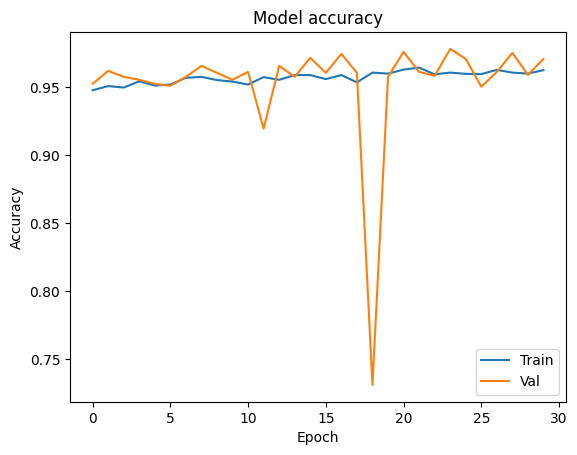

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Val'], loc='lower right')
plt.show()


In [ ]:
prediction = model.predict(X_test[136:137])
prediction = prediction[0]
print('Prediction\n',prediction)
print('\nThresholded output\n',(prediction>0.5)*1)

1/1 [==============================] - 1s 543ms/step
Prediction
 [0.93915665]

Thresholded output
 [1]


Epoch 1/10
171/171 [==============================] - 1s 2ms/step - loss: 0.4945 - accuracy: 0.8192 - val_loss: 0.3137 - val_accuracy: 0.8711
Epoch 2/10
171/171 [==============================] - 0s 2ms/step - loss: 0.3678 - accuracy: 0.8703 - val_loss: 0.2609 - val_accuracy: 0.8974
Epoch 3/10
171/171 [==============================] - 0s 2ms/step - loss: 0.3245 - accuracy: 0.8903 - val_loss: 0.2259 - val_accuracy: 0.9165
Epoch 4/10
171/171 [==============================] - 0s 2ms/step - loss: 0.2871 - accuracy: 0.9057 - val_loss: 0.1973 - val_accuracy: 0.9253
Epoch 5/10
171/171 [==============================] - 0s 2ms/step - loss: 0.2502 - accuracy: 0.9154 - val_loss: 0.1745 - val_accuracy: 0.9370
Epoch 6/10
171/171 [==============================] - 0s 2ms/step - loss: 0.2219 - accuracy: 0.9253 - val_loss: 0.1627 - val_accuracy: 0.9421
Epoch 7/10
171/171 [==============================] - 0s 2ms/step - loss: 0.2070 - accuracy: 0.9280 - val_loss: 0.1524 - val_accuracy: 0.9473
Epoch 

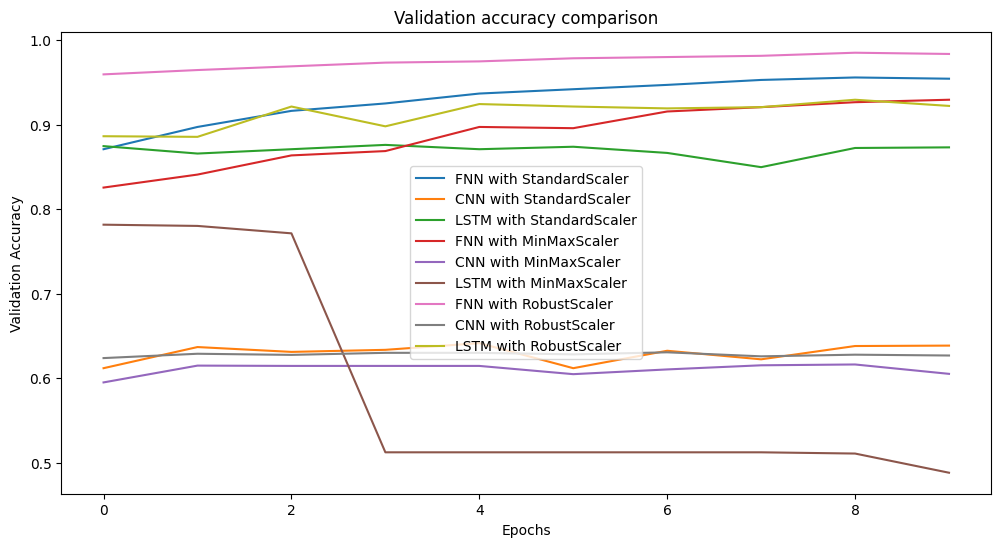

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# Define the preprocessing methods
preprocessing_methods = {'StandardScaler': StandardScaler(), 'MinMaxScaler': MinMaxScaler(), 'RobustScaler': RobustScaler()}

# Define the models
def create_fnn():
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid'),
    ])
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_cnn():
    model = Sequential([
        Conv1D(32, 3, activation='relu', input_shape=(X_train.shape[1], 1)),
        MaxPooling1D(2),
        Conv1D(64, 3, activation='relu'),
        MaxPooling1D(2),
        Dense(1, activation='sigmoid'),
    ])
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_lstm():
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)),
        LSTM(64),
        Dense(1, activation='sigmoid'),
    ])
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

models = {'FNN': create_fnn, 'CNN': create_cnn, 'LSTM': create_lstm}

import matplotlib.pyplot as plt

# Initialize a dictionary to store the history for each model
history_dict = {}

for preprocessing_name, preprocessing in preprocessing_methods.items():
    X_train_preprocessed = preprocessing.fit_transform(X_train)
    X_test_preprocessed = preprocessing.transform(X_test)

    for model_name, create_model in models.items():
        model = create_model()
        history = model.fit(X_train_preprocessed, Y_train, epochs=10, batch_size=32, validation_data=(X_test_preprocessed, Y_test))

        # Store the history
        history_dict[f'{model_name} with {preprocessing_name}'] = history

# Plot the validation accuracy of each model
plt.figure(figsize=(12, 6))

for model_name, history in history_dict.items():
    val_acc = history.history['val_accuracy']
    plt.plot(val_acc, label=model_name)

plt.title('Validation accuracy comparison')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()



In [ ]:
def combine predictions(image_path, user_data):
